## Data Preparation

### Downloading

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import shutil
import os
from tqdm import tqdm
from time import time


URL = "http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/"


def download_file(from_url, local_path):
    r = requests.get(from_url, stream=True)
    with open(local_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

def batch_download(matches):
    for match in tqdm(matches, desc='Downloading Dataset ... '):
        file_url = os.path.join(URL, match['href'])
        file_local = os.path.join('raw', match['href'])
        download_file(file_url, file_local)

def main():

    response = requests.get(URL)
    soup = BeautifulSoup(response.text, 'html.parser')
    matches = soup.find_all('a', attrs={"href": re.compile("tgz")})

    if not os.path.exists('raw'): os.mkdir('raw')
    #raw_folder = os.path.join(__file__, 'raw')
    #raw_folder = os.path.join('.', 'raw')

    batch_download(matches)


if __name__ == '__main__':
	main()

### Unzipping

In [2]:
import os
import tarfile

raw_folder = './raw/'

for f in tqdm(os.listdir(raw_folder), desc='Unzipping ... '):
    if f.endswith('.tgz'):
        tar = tarfile.open(os.path.join(raw_folder, f))
        tar.extractall(raw_folder)
        tar.close()

Unzipping ... : 100%|██████████| 6321/6321 [04:50<00:00, 21.73it/s]


### Feature Extraction

In [ ]:
import pandas as pd
import re
import scipy.stats as stats
from scipy.io import wavfile
import numpy as np
import os

# Define the path to the folder where all the uncompressed sample folders are
raw_folder = './raw'

# Define some regular expressions to homogenize the different used formats
female_pattern = re.compile('[Ff]emale')
male_pattern = re.compile('[Mm]ale')


def get_features(frequencies):

  nobs, minmax, mean, variance, skew, kurtosis =  stats.describe(frequencies)
  median   = np.median(frequencies)
  mode     = stats.mode(frequencies).mode[0]
  std      = np.std(frequencies)
  low,peak = minmax
  q75,q25  = np.percentile(frequencies, [75 ,25])
  iqr      = q75 - q25
  return nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr



def homogenize_format(readme_file):
    
    gender = 'not specified' 
    for line in open(readme_file):
      if line.startswith("Gender:"): 
        gender = line.split(":")[1].strip()
    
    #Homogenize gender format
    if female_pattern.search(gender):  gender = 'Female' 
    elif male_pattern.search(gender):  gender = 'Male'
    else: gender = 'not_specified'

    return gender



def get_frequencies(sample_wav_folder):

  #extract list of dominant frequencies in sliding windows of duration defined by 'step' for each of the 10 wav files and return an array

  frequencies_lol = [] #lol: list of lists
  for wav_file in os.listdir(sample_wav_folder):
    rate, data = wavfile.read(os.path.join(sample_wav_folder, wav_file))

    #get dominating frequencies in sliding windows of 200ms
    step = rate/5 #3200 sampling points every 1/5 sec 
    window_frequencies = []

    step = int(step)
    for i in range(0,len(data),step):
      ft = np.fft.fft(data[i:i+step]) #fft returns the list N complex numbers
      freqs = np.fft.fftfreq(len(ft)) #fftq tells you the frequencies associated with the coefficients
      imax = np.argmax(np.abs(ft))
      freq = freqs[imax]
      freq_in_hz = abs(freq *rate)
      window_frequencies.append(freq_in_hz)
      filtered_frequencies = [f for f in window_frequencies if 20<f<280 and not 46<f<66] # I see noise at 50Hz and 60Hz

    frequencies_lol.append(filtered_frequencies)

  frequencies = [item for sublist in frequencies_lol for item in sublist]

  return frequencies


def main():

  # Get a list with the names of the uncompressed folders that contain the audio files
  samples = [d for d in os.listdir(raw_folder) if os.path.isdir(os.path.join(raw_folder, d))]
  n_samples = len(samples)

  # Create an empty pandas dataframe that will contain the features
  columns=['nobs', 'mean', 'skew', 'kurtosis', 
  'median', 'mode', 'std', 'low', 
  'peak', 'q25', 'q75', 'iqr', 
  'gender' ]

  myData = pd.DataFrame(columns=columns)#, index=range(n_samples))

  # And now iterate over the samples (folders) and look into the wav folder within them to read the wav files
  for i in tqdm(range(n_samples), desc='Extracting Features ... '):

    sample = sorted(samples)[i]
    sample_folder = os.path.join(raw_folder, sample)
    sample_wav_folder = os.path.join(sample_folder, 'wav')
    readme_file = os.path.join(sample_folder, 'etc', 'README')

    if os.path.isfile(readme_file):
      gender = homogenize_format(readme_file)

    #Read and extract the information from the wav files:    
    if os.path.isdir(sample_wav_folder): #some of the samples don't contain a wav folder (Ex: 'LunaTick-20080329-vf1')
      frequencies = get_frequencies(sample_wav_folder)
      if len(frequencies) > 10: 
        #for some of the files (ex: Aaron-20130527-giy) 
        #I only recover frequencies of 0.0 (even if I don't split in chunks) which is not integrated into my lol and frequencies is empty
        nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequencies)
        sample_dict = {'nobs':nobs, 'mean':mean, 'skew':skew, 'kurtosis':kurtosis,
                       'median':median, 'mode':mode, 'std':std, 'low': low,
                       'peak':peak, 'q25':q25, 'q75':q75, 'iqr':iqr, 
                       'gender':gender}
        # print("\nappending %s sample %s : %s"%(gender, sample, sample_dict))

        myData.loc[i] = pd.Series(sample_dict)

  myData.to_csv('myData_filtered.csv')


if __name__ == '__main__':
  main()

In [7]:
import pandas as pd
mydata = pd.read_csv('myData_filtered.csv')

## Data Visualization

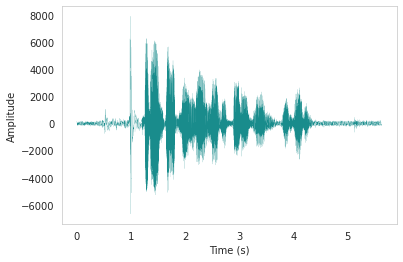

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


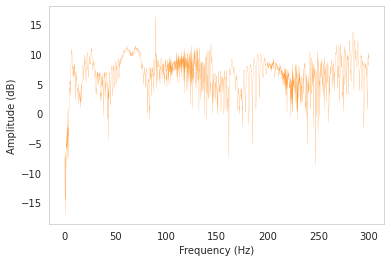

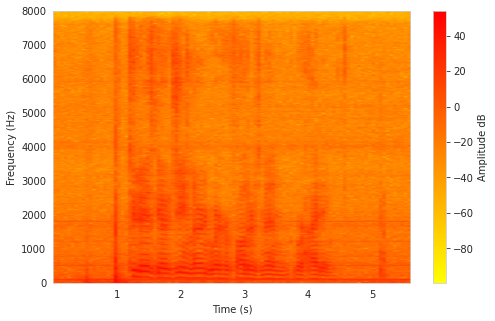

In [9]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})

#wav_file = './raw/chris-20090325-esw/wav/a0060.wav' #Noise at 50Hz #check plot_frequency
#wav_file = './raw/zeroschism-20160710/wav/cc-01.wav' #Noise at 60Hz
wav_file = 'raw/anonymous-20100621-cdr/wav/a0166.wav'

rate, data = wavfile.read(wav_file)



#plot amplitude (or loudness) over time ############
time = np.arange(0, data.shape[0], 1) / rate
plt.figure(1)
plt.subplot(111)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



#plot also frequency ##########################


fourier = np.fft.fft(data)
'''
plt.plot(fourier, color='#ff7f00')
plt.xlabel('k')
plt.ylabel('Amplitude')
'''
n = len(data)
fourier = fourier[0:(int(n/2))]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.plot(x, y, color='#ff7f00', linewidth=0.15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()


# And Heatmap ######################################


plt.figure(1, figsize=(8,5))
plt.subplot(111)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Amplitude dB')
plt.show()

## Data Distribution

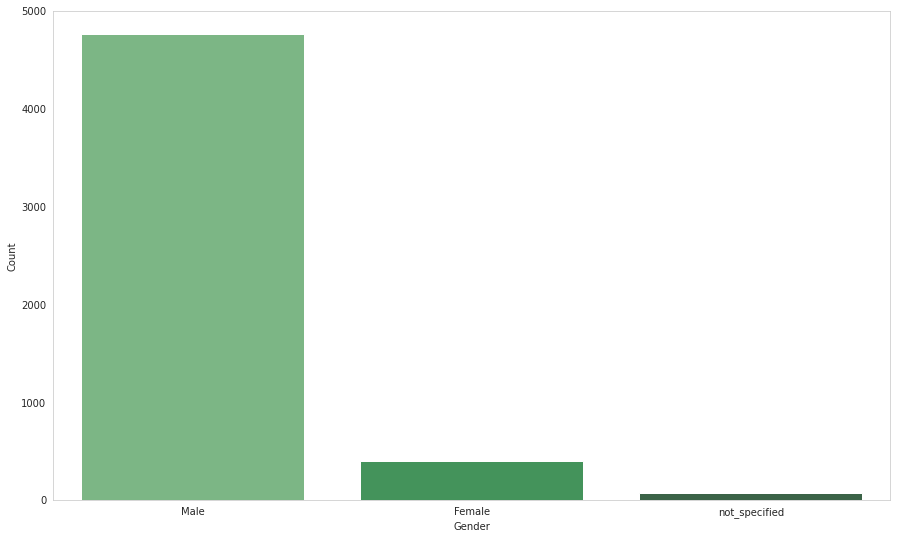

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(1,figsize=(15,9))
sb.countplot(x='gender', data=mydata, palette='Greens_d')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Classification

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set(font_scale = 2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from time import time

In [154]:
import warnings; warnings.simplefilter('ignore')
sb.set_style("whitegrid", {'axes.grid' : False})

female = mydata.loc[mydata.gender=='Female']
male = mydata.loc[mydata.gender=='Male']
#take a sample of the male population of equal size of the female (otherwise the frequencies will be much lower for female)
male_ = male.sample(len(female))

features = ['mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr']

In [155]:
#Prepare data for modeling
mydata = mydata[mydata.gender != 'not_specified']
mydata.loc[:,'gender'][mydata['gender']=="Male"] = 0
mydata.loc[:,'gender'][mydata['gender']=="Female"] = 1


#split mydata into train and test
mydata_train, mydata_test = train_test_split(mydata, random_state=0, test_size=.2)


#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(mydata_train.loc[:,features]) 
X_train = scaler.transform(mydata_train.loc[:,features])
X_test = scaler.transform(mydata_test.loc[:,features])
y_train = list(mydata_train['gender'].values)
y_test = list(mydata_test['gender'].values)


print("Logistic regression")
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
start = time()
lr.fit(X_train,y_train)
end = time()
t1_train_lr = end - start
start = time()
y_pred1_lr = lr.predict(X_test)
end = time()
t1_test_lr = end - start
print(f"Logistic Regression's accuracy with standardisation :                   {metrics.accuracy_score(y_test,y_pred1_lr)*100} %")
print(f"Logistic Regression's precision with standardisation :                  {metrics.precision_score(y_test,y_pred1_lr)*100} %")
print(f"Logistic Regression's recall with standardisation :                     {metrics.recall_score(y_test,y_pred1_lr)*100} %")
print(f"Logistic Regression's f1_score with standardisation :                   {metrics.f1_score(y_test,y_pred1_lr)*100} %")
print(f"Logistic Regression's training time with standardisation :              {t1_train_lr} s")
print(f"Logistic Regression's testing time with standardisation :               {t1_test_lr} s")


print("\nk Nearest Neighbors")
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
start = time()
knn.fit(X_train, y_train)
end = time()
t1_train_knn = end - start
start = time()
y_pred1_knn = knn.predict(X_test)
end = time()
t1_test_knn = end - start
print(f"kNN's accuracy with standardisation :                                   {metrics.accuracy_score(y_test,y_pred1_knn)*100} %")
print(f"kNN's precision with standardisation :                                  {metrics.precision_score(y_test,y_pred1_knn)*100} %")
print(f"kNN's recall with standardisation :                                     {metrics.recall_score(y_test,y_pred1_knn)*100} %")
print(f"kNN's f1_score with standardisation :                                   {metrics.f1_score(y_test,y_pred1_knn)*100} %")
print(f"kNN's training time with standardisation :                              {t1_train_knn} s")
print(f"kNN's testing time with standardisation :                               {t1_test_knn} s")


print("\nDecision Tree")
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
start = time()
tree.fit(X_train, y_train)
end = time()
t1_train_dt = end - start
start = time()
y_pred1_dt = tree.predict(X_test)
end = time()
t1_test_dt = end - start
print(f"Decision Tree's accuracy with standardisation :                         {metrics.accuracy_score(y_test,y_pred1_dt)*100} %")
print(f"Decision Tree's precision with standardisation :                        {metrics.precision_score(y_test,y_pred1_dt)*100} %")
print(f"Decision Tree's recall with standardisation :                           {metrics.recall_score(y_test,y_pred1_dt)*100} %")
print(f"Decision Tree's f1_score with standardisation :                         {metrics.f1_score(y_test,y_pred1_dt)*100} %")
print(f"Decision Tree's training time with standardisation :                    {t1_train_dt} s")
print(f"Decision Tree's testing time with standardisation :                     {t1_test_dt} s")


print("\nRandom Forst")
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier()
start = time()
rand_forest.fit(X_train, y_train)
end = time()
t1_train_rf = end - start
start = time()
y_pred1_rf = rand_forest.predict(X_test)
end = time()
t1_test_rf = end - start
print(f"Random Forest's accuracy with standardisation :                         {metrics.accuracy_score(y_test,y_pred1_rf)*100} %")
print(f"Random Forest's precision with standardisation :                        {metrics.precision_score(y_test,y_pred1_rf)*100} %")
print(f"Random Forest's recall with standardisation :                           {metrics.recall_score(y_test,y_pred1_rf)*100} %")
print(f"Random Forest's f1_score with standardisation :                         {metrics.f1_score(y_test,y_pred1_rf)*100} %")
print(f"Random Forest's training time with standardisation :                    {t1_train_rf} s")
print(f"Random Forest's testing time with standardisation :                     {t1_test_rf} s")


print("\nGradient Boosting")
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier()
start = time()
tree.fit(X_train, y_train)
end = time()
t1_train_gb = end - start
start = time()
y_pred1_gb = tree.predict(X_test)
end = time()
t1_test_gb = end - start
print(f"Gradient Boosting's accuracy with standardisation :                     {metrics.accuracy_score(y_test,y_pred1_gb)*100} %")
print(f"Gradient Boosting's precision with standardisation :                    {metrics.precision_score(y_test,y_pred1_gb)*100} %")
print(f"Gradient Boosting's recall with standardisation :                       {metrics.recall_score(y_test,y_pred1_gb)*100} %")
print(f"Gradient Boosting's f1_score with standardisation :                     {metrics.f1_score(y_test,y_pred1_gb)*100} %")
print(f"Gradient Boosting's training time with standardisation :                {t1_train_gb} s")
print(f"Gradient Boosting's testing time with standardisation :                 {t1_test_gb} s")


print("\nSupport Vector Machine")
from sklearn.svm import SVC
svc = SVC()
start = time()
svc.fit(X_train, y_train)
end = time()
t1_train_svm = end - start
start = time()
y_pred1_svm = svc.predict(X_test)
end = time()
t1_test_svm = end - start
print(f"Support Vector Machine's accuracy with standardisation :                {metrics.accuracy_score(y_test,y_pred1_svm)*100} %")
print(f"Support Vector Machine's precision with standardisation :               {metrics.precision_score(y_test,y_pred1_svm)*100} %")
print(f"Support Vector Machine's recall with standardisation :                  {metrics.recall_score(y_test,y_pred1_svm)*100} %")
print(f"Support Vector Machine's f1_score with standardisation :                {metrics.f1_score(y_test,y_pred1_svm)*100} %")
print(f"Support Vector Machine's training time with standardisation :           {t1_train_svm} s")
print(f"Support Vector Machine's testing time with standardisation :            {t1_test_svm} s")


print("\nNeural Network")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time()
tree.fit(X_train, y_train)
end = time()
t1_train_nn = end - start
start = time()
y_pred1_nn = tree.predict(X_test)
end = time()
t1_test_nn = end - start
print(f"Neural Network's accuracy with standardisation :                        {metrics.accuracy_score(y_test,y_pred1_nn)*100} %")
print(f"Neural Network's precision with standardisation :                       {metrics.precision_score(y_test,y_pred1_nn)*100} %")
print(f"Neural Network's recall with standardisation :                          {metrics.recall_score(y_test,y_pred1_nn)*100} %")
print(f"Neural Network's f1_score with standardisation :                        {metrics.f1_score(y_test,y_pred1_nn)*100} %")
print(f"Neural Network's training time with standardisation :                   {t1_train_nn} s")
print(f"Neural Network's testing time with standardisation :                    {t1_test_nn} s")

Logistic regression
Logistic Regression's accuracy with standardisation :                   90.70667957405615 %
Logistic Regression's precision with standardisation :                  0.0 %
Logistic Regression's recall with standardisation :                     0.0 %
Logistic Regression's f1_score with standardisation :                   0.0 %
Logistic Regression's training time with standardisation :              0.025836467742919922 s
Logistic Regression's testing time with standardisation :               0.0002582073211669922 s

k Nearest Neighbors
kNN's accuracy with standardisation :                                   92.64278799612778 %
kNN's precision with standardisation :                                  66.12903225806451 %
kNN's recall with standardisation :                                     42.70833333333333 %
kNN's f1_score with standardisation :                                   51.89873417721519 %
kNN's training time with standardisation :                              0.

In [156]:
# can not be used because of the existance of negetive values in X

# from re import S
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB()
# start = time()
# clf.fit(X_train, y_train)
# end = end()
# t1_train_nb = end - start
# start = time()
# y_pred1_nb = clf.predict(X_test)
# end = time()
# t1_test_nb = end - start
# print(f"Naïve Bayes's accuracy with standardisation :                         {metrics.accuracy_score(y_test,y_pred1_nb)*100} %")
# print(f"Naïve Bayes's precision with standardisation :                        {metrics.precision_score(y_test,y_pred1_nb)*100} %")
# print(f"Naïve Bayes's recall with standardisation :                           {metrics.recall_score(y_test,y_pred1_nb)*100} %")
# print(f"Naïve Bayes's f1_score with standardisation :                         {metrics.f1_score(y_test,y_pred1_nb)*100} %")
# print(f"Naïve Bayes's training time with standardisation :                    {t1_train_nb} s")
# print(f"Naïve Bayes's testing time with standardisation :                     {t1_test_nb} s")

# Results

In [19]:
def plot_feature_importances_mydata(model, c):
    n_features = len(features)
    plt.figure(1,figsize=(18,10))
    plt.bar(range(n_features), model.feature_importances_, align='center', color=c)
    plt.xticks(np.arange(n_features), features)
    plt.ylabel("Variable importance")
    plt.xlabel("Independent Variable")
    plt.title(model.__class__.__name__)
    plt.show()

In [ ]:
plot_feature_importances_mydata(lr,  '#ff0000')

In [ ]:
plot_feature_importances_mydata(knn, '#00ff00')

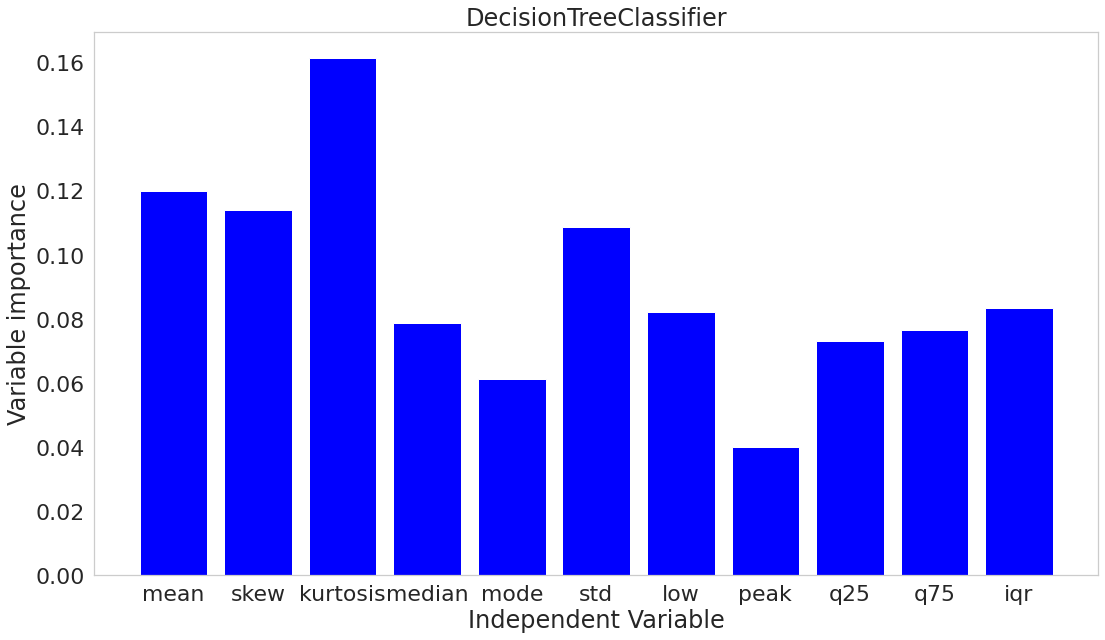

In [22]:
plot_feature_importances_mydata(tree, '#0000ff')

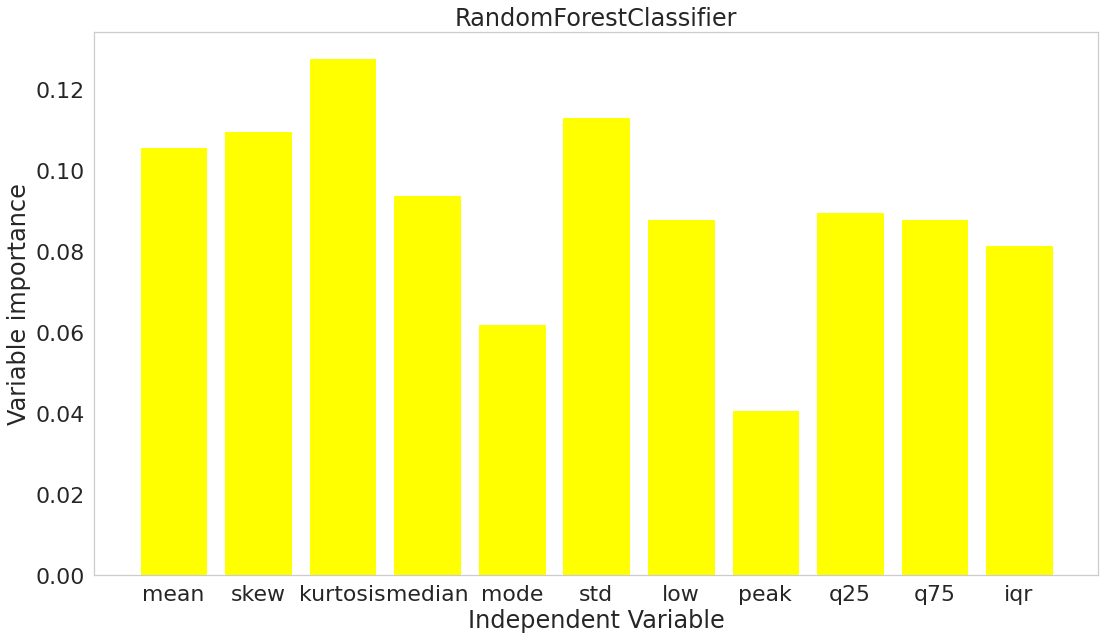

In [23]:
plot_feature_importances_mydata(rand_forest, '#ffff00')

In [ ]:
plot_feature_importances_mydata(gbrt, '#ff00ff')

In [ ]:
plot_feature_importances_mydata(svc, '#00ffff')

In [ ]:
plot_feature_importances_mydata(mlp, '#f0f0f0')

In [ ]:
#Plot the heatmap on first layer weights for neural network
plt.figure(figsize=(50, len(features)))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(features)), features)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar().set_label('Importance')

plt.show()

In [ ]:
Accuracy = {}
Precision = {}
Recall = {}
F1_score = {}
Training_time = {}
Testing_time = {}

# **Testing**

In [91]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment 
from pydub.utils import make_chunks
import os

def process_sudio(file_name):
    myaudio = AudioSegment.from_file(file_name, "wav") 
    chunk_length_ms = 6000 # pydub calculates in millisec 
    chunks = make_chunks(myaudio,chunk_length_ms) #Make chunks of one sec 
    for i, chunk in enumerate(chunks):
        if i<10:
          chunk_name = '/content/test/test2/wav/' + file_name.split('.')[0] + "_{0}.wav".format(i) 
          print ("exporting", chunk_name) 
          chunk.export(chunk_name, format="wav") 

all_file_names = os.listdir(".")
try:
    os.makedirs('chunked') # creating a folder named chunked
except:
    pass
for each_file in all_file_names:
    if ('.wav' in each_file):
        process_sudio(each_file)

In [162]:
test_folder = "/content/test/test/wav"
if os.path.isdir(test_folder):
  frequencies = get_frequencies(test_folder)
  if len(frequencies) > 10: 
    nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequencies)

X_testt = mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr
X_testtt = [[]]
for a in X_testt:
  X_testtt[0].append(a)
print(X_testtt)
X_testtt = (X_testtt-scaler.mean_)/scaler.var_
print(X_testtt,'\n')


test_folder2 = "/content/test/test2/wav"
if os.path.isdir(test_folder2):
  frequencies = get_frequencies(test_folder2)
  if len(frequencies) > 10: 
    nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequencies)

X_testt2 = mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr
X_testtt2 = [[]]
for a in X_testt2:
  X_testtt2[0].append(a)
print(X_testtt2)
X_testtt2 = (X_testtt2-scaler.mean_)/scaler.var_
print(X_testtt2,'\n')

[[170.14285714285714, 0.5278955207101355, -1.0152188464843717, 165.0, 130.0, 50.11632726470887, 110.0, 275.0, 125.00000000000001, 210.00000000000003, 85.00000000000001]]
[[ 1.49982636e-02  1.06494866e-01 -3.14742370e-02  8.93126096e-03
   2.66433189e-05  5.87952214e-03  3.13677762e-02  1.99413655e-02
   4.08575822e-03  1.28499160e-02  1.19899003e-02]] 

[[233.5648148148148, -0.7455903119979911, 0.45940657321309075, 240.0, 250.00000000000003, 27.318855633314048, 145.00000000000003, 275.0, 215.0, 255.00000000000003, 40.00000000000003]]
[[ 0.05749081 -0.54797764 -0.01678579  0.04140951  0.03304571 -0.0621993
   0.05182129  0.01994137  0.04814523  0.03037172 -0.00989341]] 



In [ ]:
wav_file = './test/test/wav/test_0.wav'

rate, data = wavfile.read(wav_file)


#plot amplitude (or loudness) over time ############
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.figure(1)
plt.subplot(321)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


#plot also frequency ##########################


fourier = np.fft.fft(data)
'''
plt.plot(fourier, color='#ff7f00')
plt.xlabel('k')
plt.ylabel('Amplitude')
'''
n = len(data)
fourier = fourier[0:(int(n/2))]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.subplot(322)
plt.plot(x, y, color='#ff7f00', linewidth=0.15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()


# And Heatmap ######################################


plt.figure(1, figsize=(8,5))
plt.subplot(323)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Amplitude dB')
plt.show()


wav_file = './test/test2/wav/test2_0.wav'

rate, data = wavfile.read(wav_file)


#plot amplitude (or loudness) over time ############
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.figure(1)
plt.subplot(324)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


#plot also frequency ##########################


fourier = np.fft.fft(data)
'''
plt.plot(fourier, color='#ff7f00')
plt.xlabel('k')
plt.ylabel('Amplitude')
'''
n = len(data)
fourier = fourier[0:(int(n/2))]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.subplot(325)
plt.plot(x, y, color='#ff7f00', linewidth=0.15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()


# And Heatmap ######################################


plt.figure(1, figsize=(8,5))
plt.subplot(326)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Amplitude dB')
plt.show()

In [161]:
print("Logistic regression")
lr.fit(X_train, y_train)
y_pred1_lr = lr.predict(X_testtt)
y_pred2_lr = lr.predict(X_testtt2)
print(y_pred1_lr)
print(y_pred2_lr)


print("\nk Nearest Neighbors")
knn.fit(X_train, y_train)
y_pred1_knn = knn.predict(X_testtt)
y_pred2_knn = knn.predict(X_testtt2)
print(y_pred1_knn)
print(y_pred2_knn)


print("\nDecision Tree")
tree.fit(X_train, y_train)
y_pred1_dt = tree.predict(X_testtt)
y_pred2_dt = tree.predict(X_testtt2)
print(y_pred1_dt)
print(y_pred2_dt)


print("\nRandom Forst")
rand_forest.fit(X_train, y_train)
y_pred1_rf = rand_forest.predict(X_testtt)
y_pred2_rf = rand_forest.predict(X_testtt2)
print(y_pred1_rf)
print(y_pred2_rf)


print("\nGradient Boosting")
gbrt.fit(X_train, y_train)
y_pred1_gb = gbrt.predict(X_testtt)
y_pred2_gb = gbrt.predict(X_testtt2)
print(y_pred1_gb)
print(y_pred2_gb)


print("\nSupport Vector Machine")
svc.fit(X_train, y_train)
y_pred1_svm = svc.predict(X_testtt)
y_pred2_svm = svc.predict(X_testtt2)
print(y_pred1_svm)
print(y_pred2_svm)


print("\nNeural Network")
mlp.fit(X_train, y_train)
y_pred1_nn = mlp.predict(X_testtt)
y_pred2_nn = mlp.predict(X_testtt2)
print(y_pred1_nn)
print(y_pred2_nn)

Logistic regression
[0]
[0]

k Nearest Neighbors
[0]
[0]

Decision Tree
[0]
[0]

Random Forst
[0]
[0]

Gradient Boosting
[0]
[0]

Support Vector Machine
[0]
[0]

Neural Network
[0]
[0]
